# Unit test notebook for Fission Fragment 1

In [1]:
from cheftgp.eft import *
from cheftgp.gaussianprocess_refactored import *
from cheftgp.graphs import *
from cheftgp.scattering import *
from cheftgp.utils import *
from cheftgp.potentials import *

import scipy
from scipy.stats import multivariate_normal
from scipy.optimize import curve_fit
from scipy.interpolate import interpn

## Plots of length scale and variance by order for different potentials

#### Sets meshes and extracts coefficients from the data for a particular observable and potential

In [2]:
# sets the potential of interest
ScaleScheme = RKE500MeV

In [3]:
# choose energy and angle meshes
t_lab = ScaleScheme.get_data("t_lab")

t_lab_input = E_to_p(E_lab = t_lab, interaction = "np")
X_train_tlab = E_to_p(E_lab = np.array([5, 21, 48, 85, 133, 192, 261]), 
                     interaction = "np")[:, None]
t_lab_label = "Relative momentum (MeV)"
# t_lab_input = t_lab
# X_train_tlab = np.array([5, 21, 48, 85, 133, 192, 261])[:, None]
# t_lab_label = "Lab energy (MeV)"

X_tlab = t_lab_input[:, None]
t_lab_subset = t_lab_input[0::10]

degrees = ScaleScheme.get_data("degrees")

# degrees_input = degrees
# X_train_deg = np.array([1, 30, 60, 90, 120, 150, 179])[:, None]
# degrees_label = "Scattering angle (degrees)"
degrees_input = -np.cos(np.radians(degrees))
X_train_deg = -np.cos(np.radians(np.array([1, 30, 60, 90, 120, 150, 179])))[:, None]
degrees_label = "Negative cosine"

X_deg = degrees_input[:, None]
degrees_subset = degrees_input[0::10]
# degrees_subset = np.linspace(start = np.min(degrees_input), 
#                            stop = np.max(degrees_input), 
#                            num = 35, 
#                            dtype = int)

# extracts data
obs_data_name = "DSG"
obs_data = ScaleScheme.get_data(obs_data_name)

Lambda_b_coeffs = 600
mpi_eff_coeffs = 200

# sets reference scale
if obs_data_name == "DSG":
    yref = obs_data[-1, :, :]
else:
    yref = np.ones(np.shape(obs_data)[1:])

# calculates ratio
p_type = "pprel"
p_grid = p_approx(p_name = p_type, 
                 prel = E_to_p(E_lab = t_lab, interaction = "np"), 
                 degrees = degrees).T
Q_type = "sum"
ratio = Q_approx(p = p_grid, 
                 Q_parametrization = Q_type, 
                 Lambda_b = Lambda_b_coeffs, 
                 m_pi = mpi_eff_coeffs,
                 single_expansion=False)

# extracts coefficients
coeffs_flattened = gm.coefficients(
            np.reshape(obs_data, (np.shape(obs_data)[0], np.shape(obs_data)[1] * np.shape(obs_data)[2])).T, 
            ratio=np.reshape(ratio, np.shape(ratio)[0] * np.shape(ratio)[1]),
            ref=np.reshape(yref, np.shape(yref)[0] * np.shape(yref)[1]), 
            orders=ScaleScheme.orders_full)
coeffs_surfaces = np.reshape(coeffs_flattened.T, np.shape(obs_data))

#### Plots of scattering-angle length scale and variance by order

C:\Users\pjmil\anaconda3\envs\modern-nn-potentials\lib\site-packages\gsum\models.py:664: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  optima = np.array(optima)
C:\Users\pjmil\AppData\Local\Temp\ipykernel_9768\1752760707.py:51: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  (axs_tlab_ls.flat)[o].scatter(t,
C:\Users\pjmil\AppData\Local\Temp\ipykernel_9768\1752760707.py:57: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping w

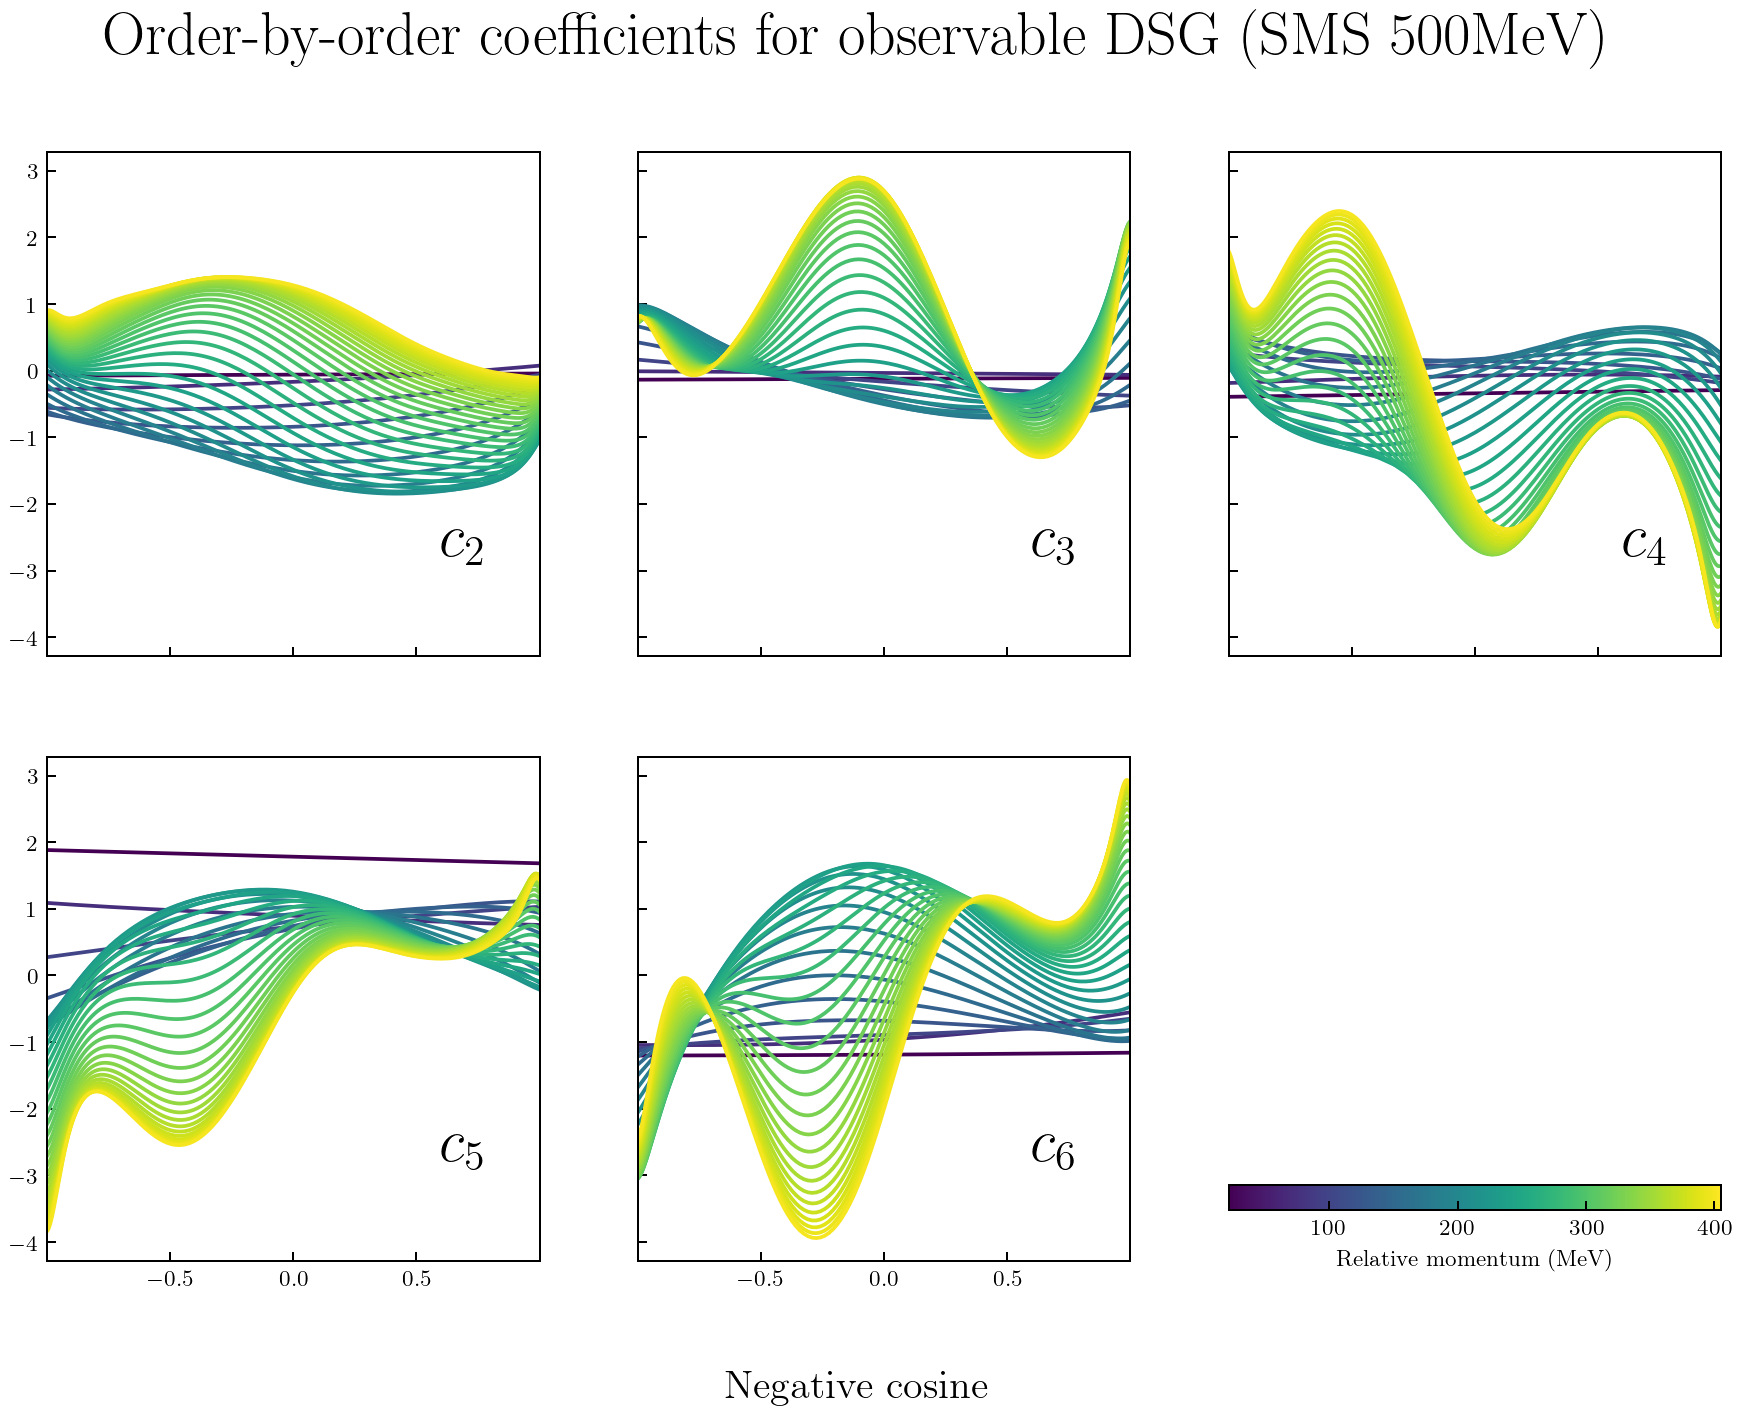

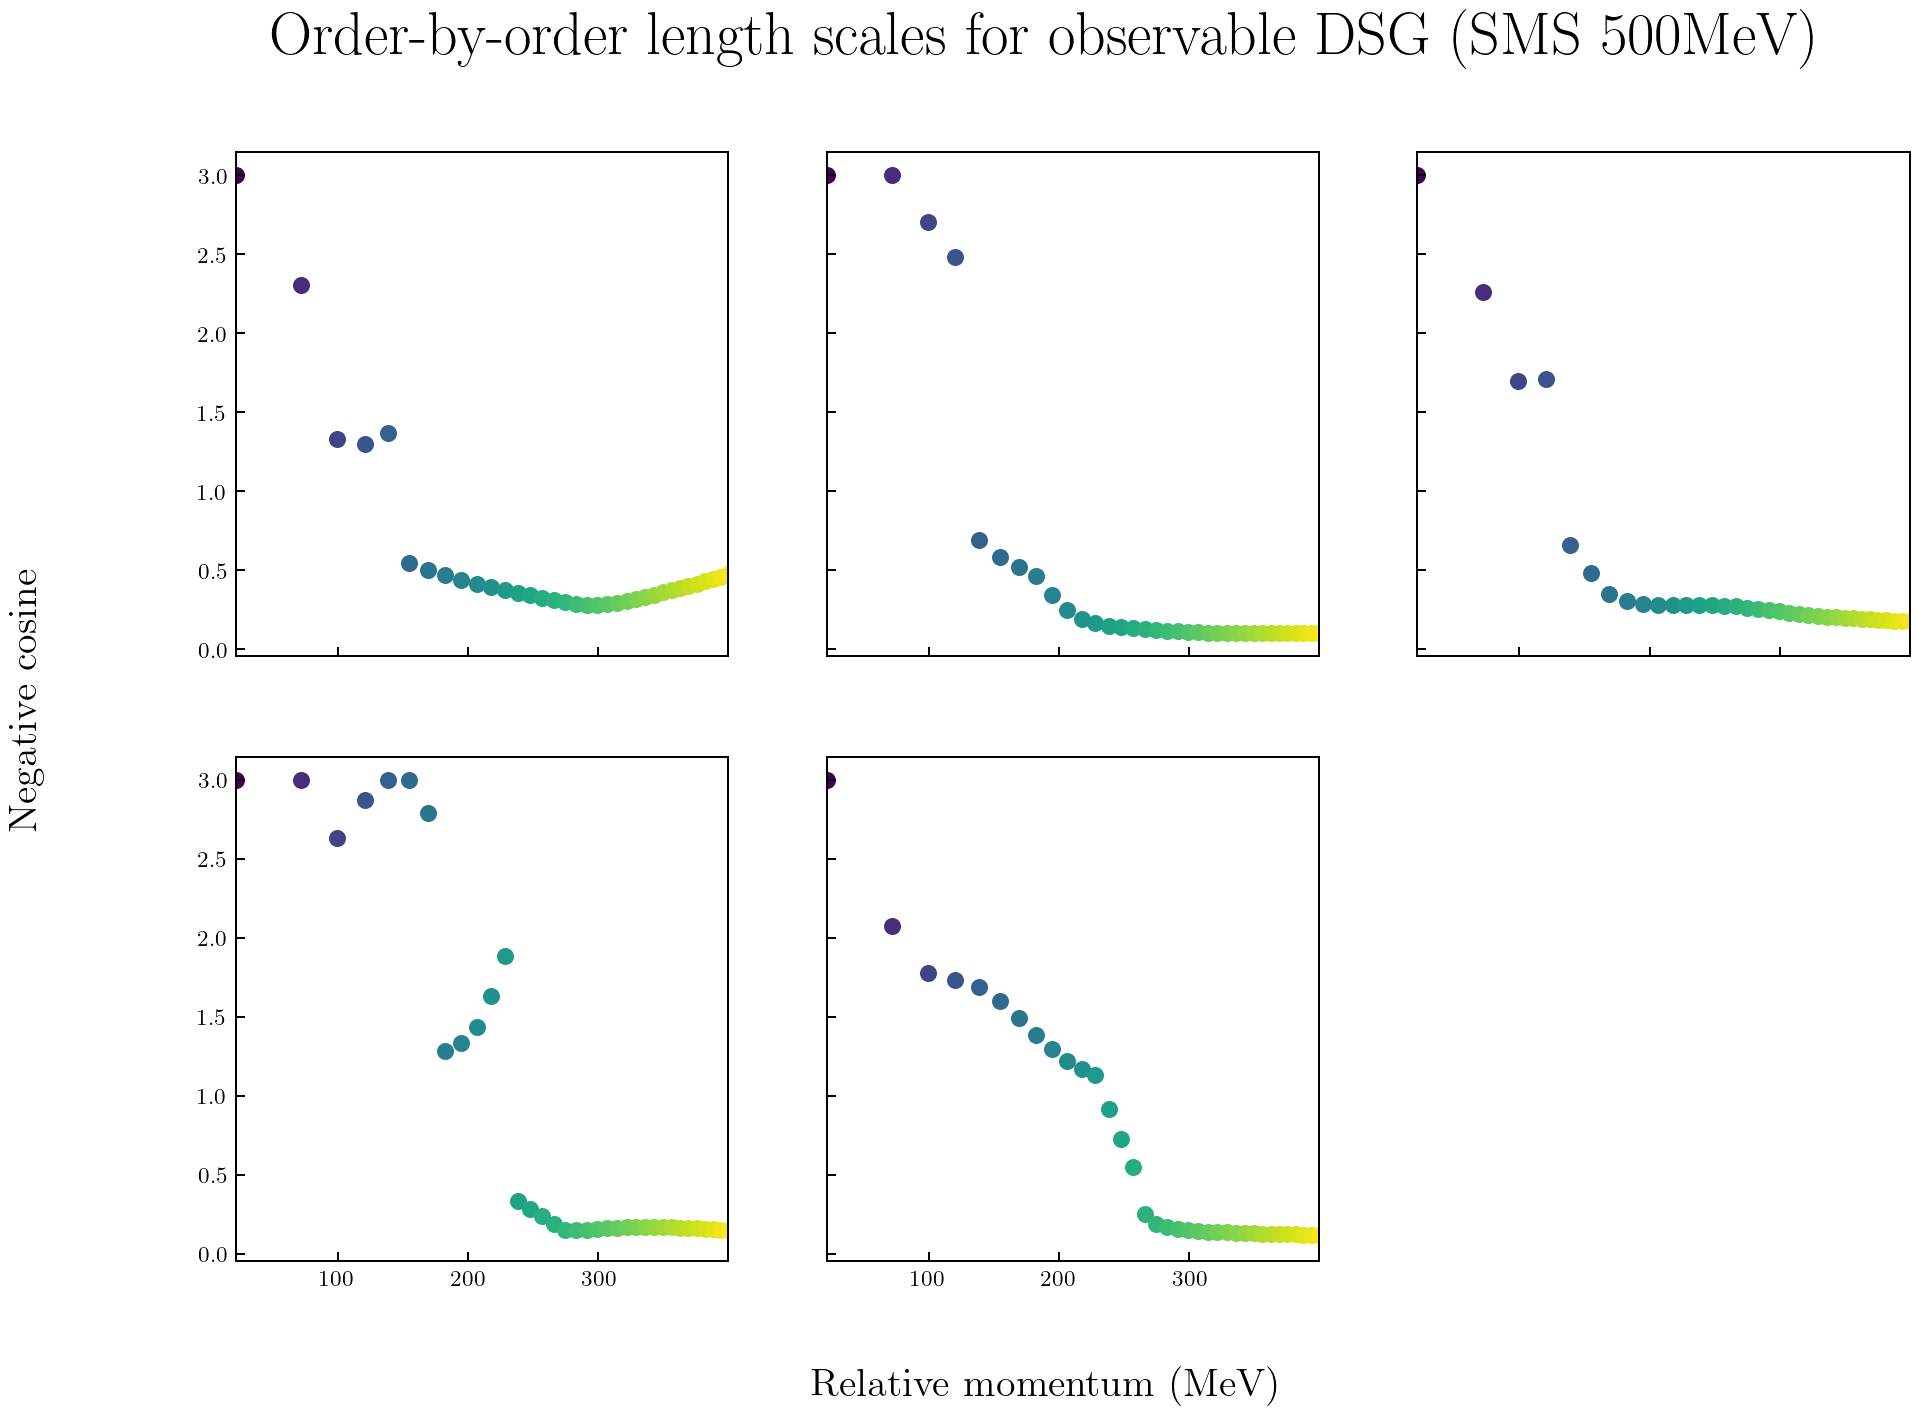

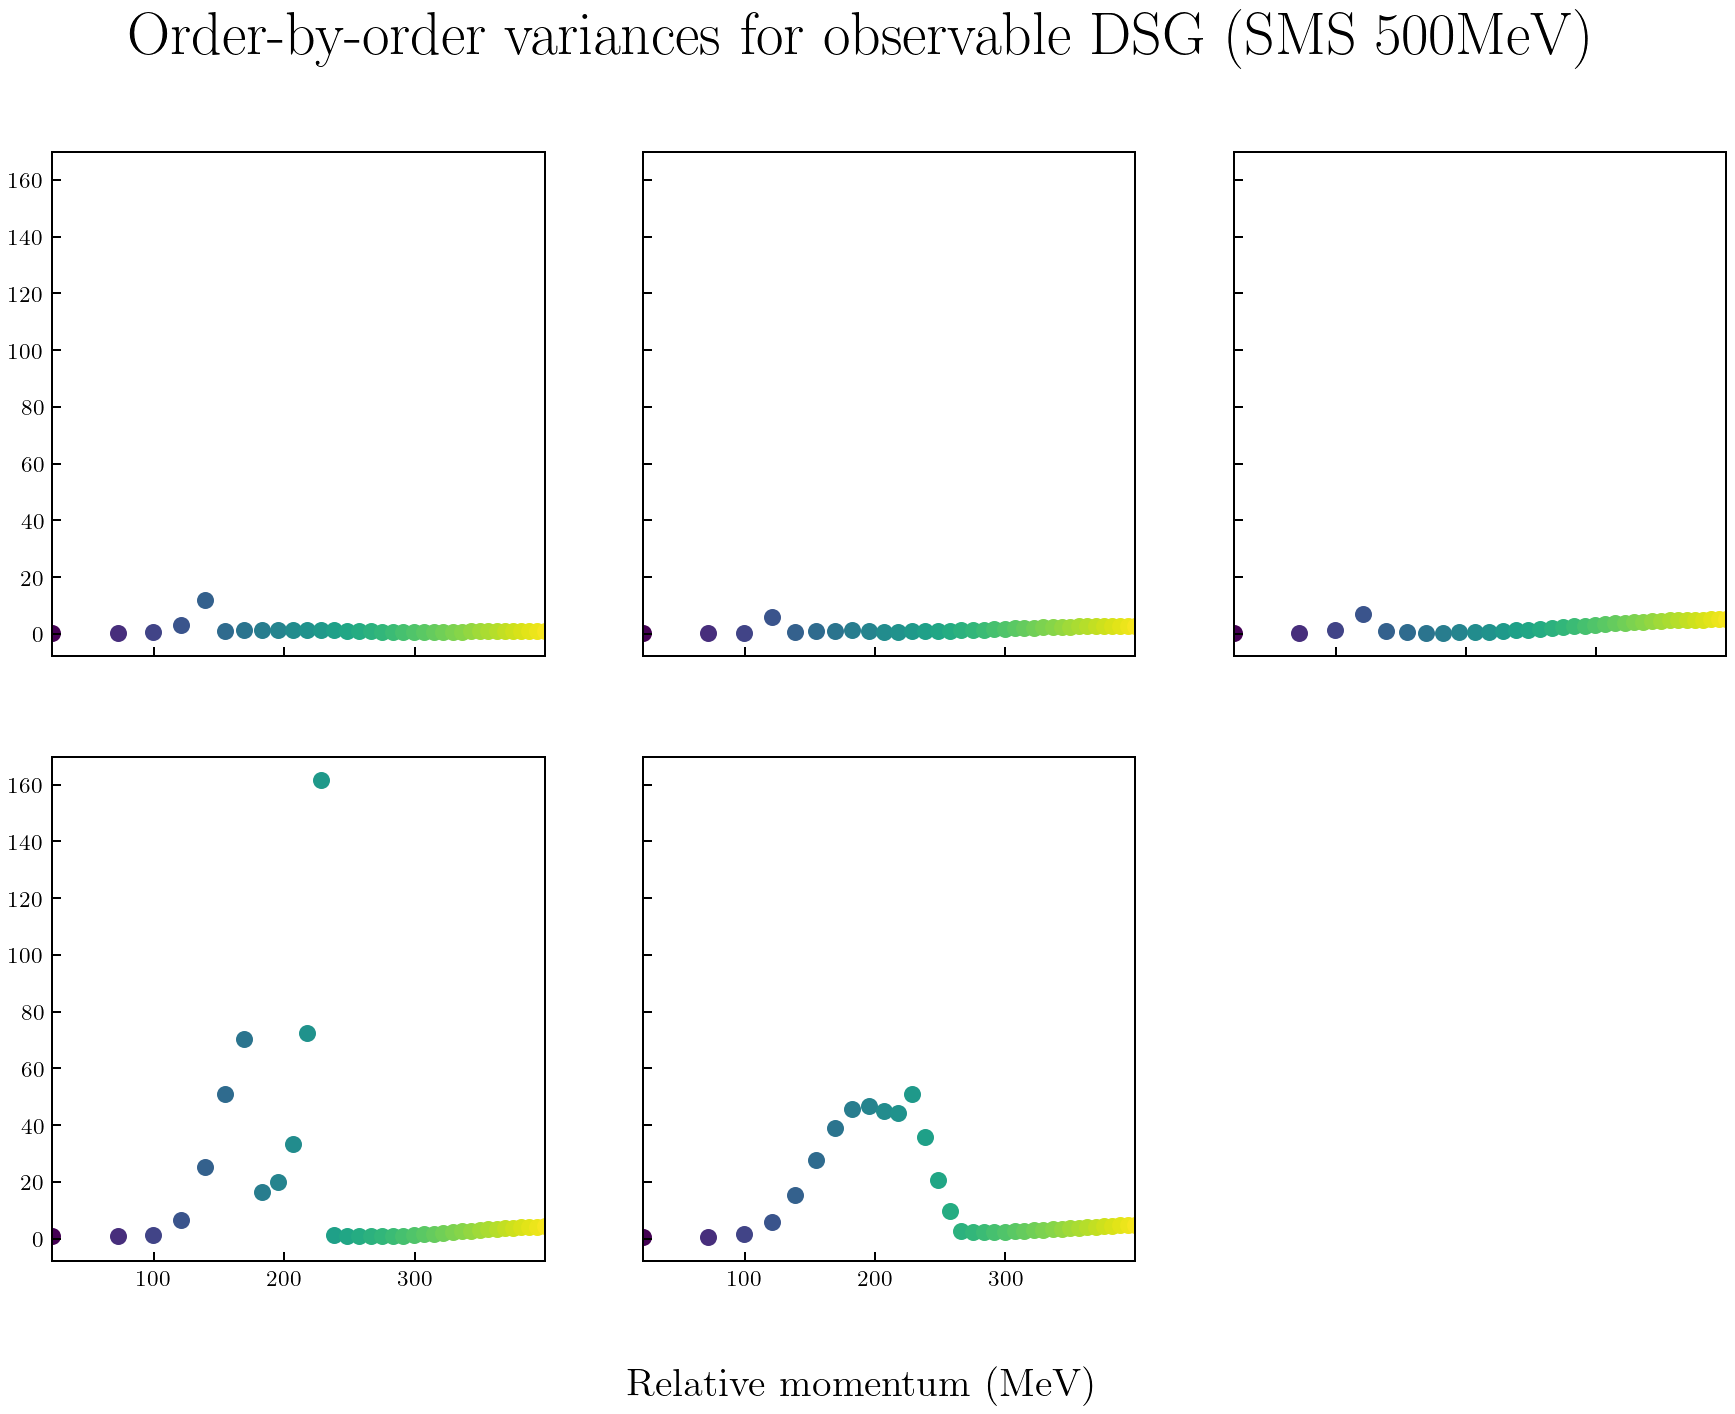

In [4]:
# choose colormap and fix to different energies
cmap_tlab = mpl.cm.viridis
norm_tlab = mpl.colors.Normalize(vmin=np.min(t_lab_input), vmax=np.max(t_lab_input))

# create figure with n_orders subplots
fig_tlab_coeffs, axs_tlab_coeffs = plt.subplots(2, 3, sharex = True, sharey=True, figsize=(12, 8))
fig_tlab_coeffs.supxlabel(degrees_label, size = 16)
fig_tlab_coeffs.suptitle('Order-by-order coefficients for observable ' + obs_data_name + " (" + 
             ScaleScheme.potential_string + " " + ScaleScheme.cutoff_string + ")", size = 24)

# create figure with n_orders subplots
fig_tlab_ls, axs_tlab_ls = plt.subplots(2, 3, sharex = True, sharey=True, figsize=(12, 8))
fig_tlab_ls.supxlabel(t_lab_label, size = 16)
fig_tlab_ls.supylabel(degrees_label, size = 16)
fig_tlab_ls.suptitle('Order-by-order length scales for observable ' + obs_data_name + " (" + 
             ScaleScheme.potential_string + " " + ScaleScheme.cutoff_string + ")", size = 24)

# create figure with n_orders subplots
fig_tlab_var, axs_tlab_var = plt.subplots(2, 3, sharex = True, sharey=True, figsize=(12, 8))
fig_tlab_var.supxlabel(t_lab_label, size = 16)
fig_tlab_var.suptitle('Order-by-order variances for observable ' + obs_data_name + " (" + 
             ScaleScheme.potential_string + " " + ScaleScheme.cutoff_string + ")", size = 24)

# plot at each energy in mesh
for o in range(np.shape(coeffs_surfaces)[0] - 1):
    (axs_tlab_coeffs.flat)[o].text(0.8, 0.2, 
                       rf'$c_{{{ScaleScheme.orders_full[o + 1]}}}$', 
                       transform=(axs_tlab_coeffs.flat)[o].transAxes, 
                       size = 24)
        
    for t in t_lab_subset:
        (axs_tlab_coeffs.flat)[o].plot(degrees_input, 
                    coeffs_surfaces[o + 1, np.isin(t_lab_input, t), :].T, 
                    c = mpl.cm.ScalarMappable(norm=norm_tlab, cmap=cmap_tlab).to_rgba(t))
        
        gp = gm.ConjugateGaussianProcess(
            RBF(length_scale=0.25 * (np.max(degrees_input) - np.min(degrees_input)),
                      length_scale_bounds=(0.05 * (np.max(degrees_input) - np.min(degrees_input)), 
                                           2 * (np.max(degrees_input) - np.min(degrees_input)))
               ) + WhiteKernel(1e-5, noise_level_bounds='fixed'),
            center=0, 
            disp=0, 
            df=1,
            scale=1, 
            n_restarts_optimizer=100, 
            random_state=None,
            sd=None)
        gp.fit(X_train_deg, 
               (coeffs_surfaces[o + 1, np.isin(t_lab_input, t), :].T)[np.isin(degrees_input, X_train_deg)])
        ls_fit = np.exp(gp.kernel_.theta)
        (axs_tlab_ls.flat)[o].scatter(t, 
                    ls_fit, 
                    c = mpl.cm.ScalarMappable(norm=norm_tlab, cmap=cmap_tlab).to_rgba(t))
        
        pred, std = gp.predict(X_deg, return_std=True)
        underlying_std = gp.cov_factor_
        (axs_tlab_var.flat)[o].scatter(t, 
                    underlying_std, 
                    c = mpl.cm.ScalarMappable(norm=norm_tlab, cmap=cmap_tlab).to_rgba(t))

fig_tlab_coeffs.delaxes(axs_tlab_coeffs[-1, -1])        
fig_tlab_coeffs.colorbar(mpl.cm.ScalarMappable(norm=norm_tlab, cmap=cmap_tlab), 
            ax = axs_tlab_coeffs[-1, -1],
             orientation='horizontal', label=t_lab_label)

fig_tlab_ls.delaxes(axs_tlab_ls[-1, -1])
fig_tlab_var.delaxes(axs_tlab_var[-1, -1])

# saves figures
fig_tlab_coeffs.savefig('figures2/' + 'coeffs' + '_' + 'tlab_slices' + '_' + 'orderbyorder' + '_' +
                    ScaleScheme.potential_string + ScaleScheme.cutoff_string + '_' +
                    obs_data_name + '_Q' + Q_type + '_' + p_type + '_' + 'prel' + '_' + 
                    'degrees')
fig_tlab_ls.savefig('figures2/' + 'ls' + '_' + 'tlab_slices' + '_' + 'orderbyorder' + '_' +
                    ScaleScheme.potential_string + ScaleScheme.cutoff_string + '_' +
                    obs_data_name + '_Q' + Q_type + '_' + p_type + '_' + 'prel' + '_' + 
                    'degrees')
fig_tlab_var.savefig('figures2/' + 'var' + '_' + 'tlab_slices' + '_' + 'orderbyorder' + '_' +
                    ScaleScheme.potential_string + ScaleScheme.cutoff_string + '_' +
                    obs_data_name + '_Q' + Q_type + '_' + p_type + '_' + 'prel' + '_' + 
                    'degrees')

#### Plots of scattering-angle length scale and variance over all orders

C:\Users\pjmil\AppData\Local\Temp\ipykernel_9768\3959018432.py:39: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  axs_tlab_ls_all.scatter(t,
C:\Users\pjmil\AppData\Local\Temp\ipykernel_9768\3959018432.py:45: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  axs_tlab_var_all.scatter(t,
C:\Users\pjmil\anaconda3\envs\modern-nn-potentials\lib\site-packages\gsum\models.py:891: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally wi

[41.91114248 -0.81294908]


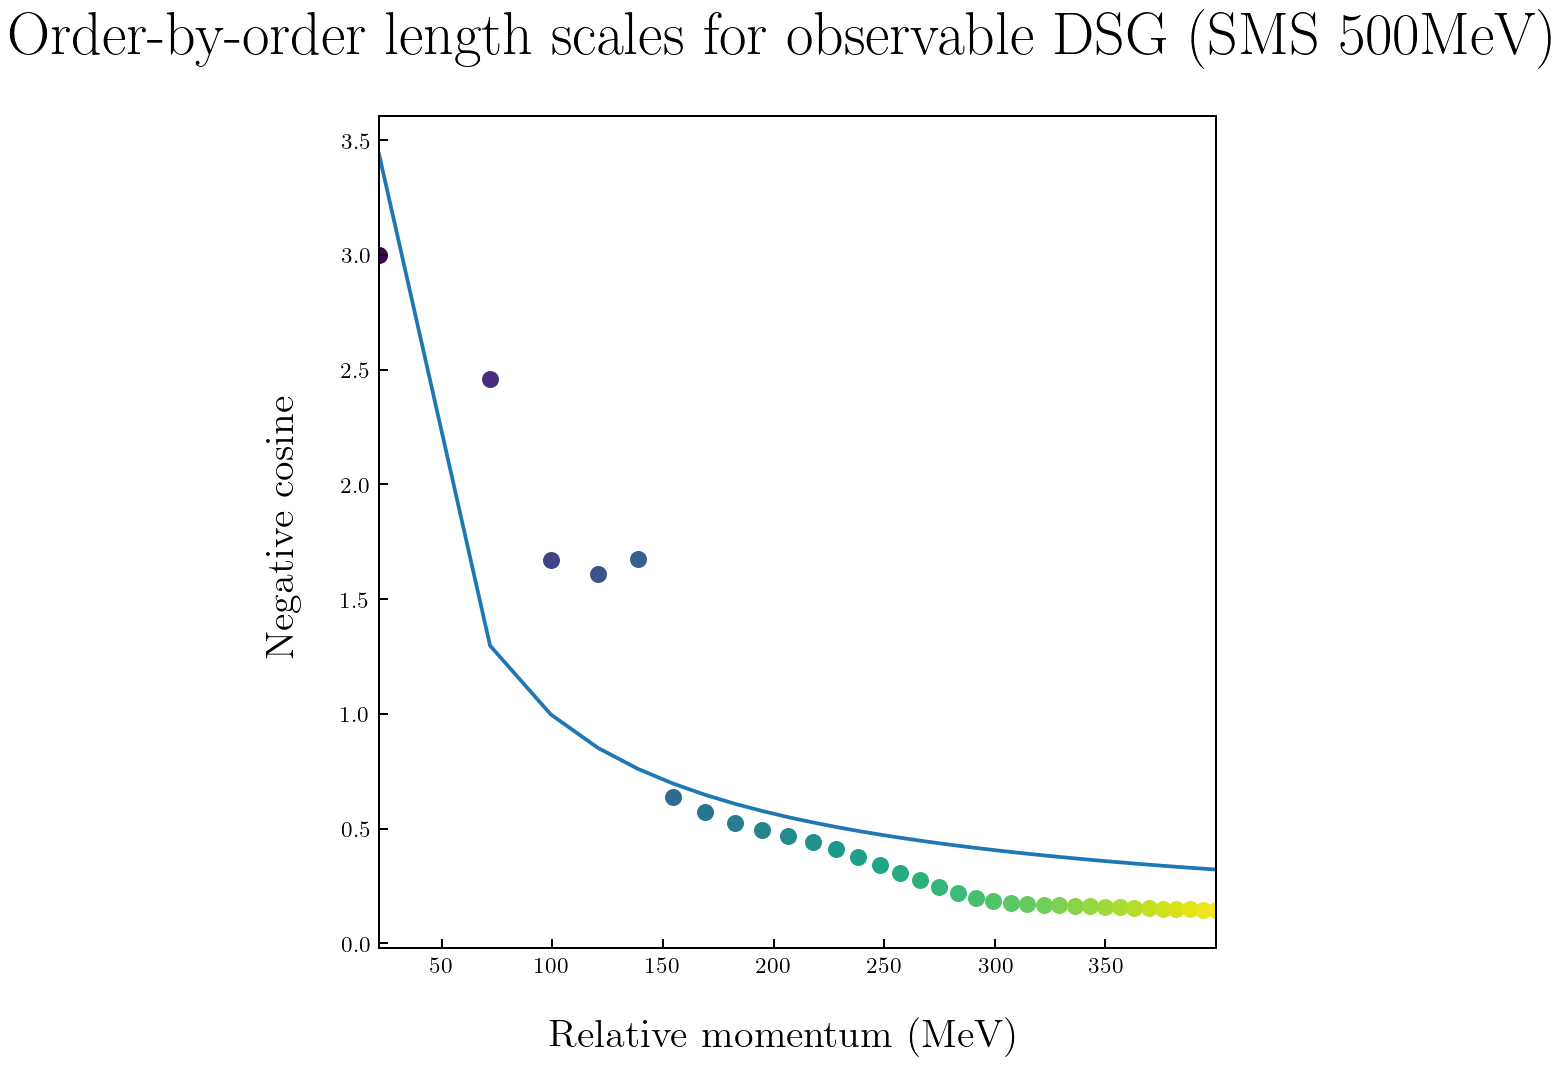

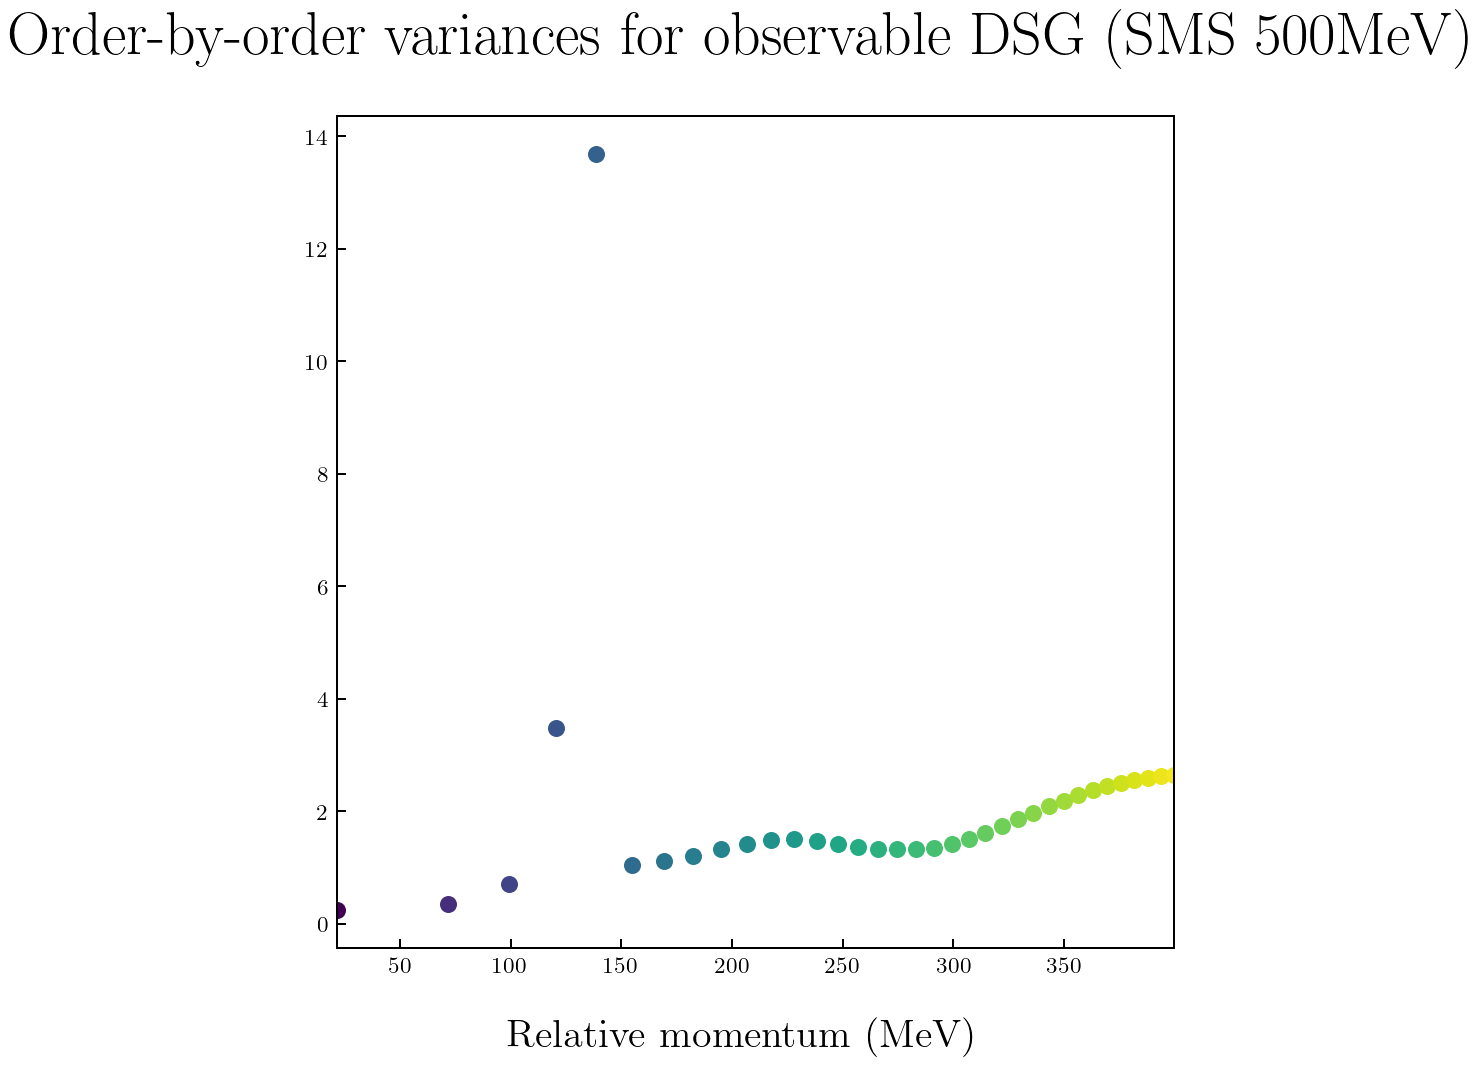

In [5]:
# create figure with n_orders subplots
fig_tlab_ls_all, axs_tlab_ls_all = plt.subplots(1, 1, sharex = True, sharey=True, figsize=(6, 6))
fig_tlab_ls_all.supxlabel(t_lab_label, size = 16)
fig_tlab_ls_all.supylabel(degrees_label, size = 16)
fig_tlab_ls_all.suptitle('Order-by-order length scales for observable ' + obs_data_name + " (" + 
             ScaleScheme.potential_string + " " + ScaleScheme.cutoff_string + ")", size = 24)
# axs_tlab_ls_all.semilogx()
# axs_tlab_ls_all.semilogy()

axs_tlab_ls_all_array = np.array([])

# create figure with n_orders subplots
fig_tlab_var_all, axs_tlab_var_all = plt.subplots(1, 1, sharex = True, sharey=True, figsize=(6, 6))
fig_tlab_var_all.supxlabel(t_lab_label, size = 16)
fig_tlab_var_all.suptitle('Order-by-order variances for observable ' + obs_data_name + " (" + 
             ScaleScheme.potential_string + " " + ScaleScheme.cutoff_string + ")", size = 24)
# axs_tlab_var_all.semilogx()
# axs_tlab_var_all.semilogy()

# plots at each energy in mesh
for t in t_lab_subset:
    gp = gm.ConjugateGaussianProcess(
        RBF(length_scale=0.25 * (np.max(degrees_input) - np.min(degrees_input)),
                      length_scale_bounds=(0.05 * (np.max(degrees_input) - np.min(degrees_input)), 
                                           1.5 * (np.max(degrees_input) - np.min(degrees_input)))
               ) + WhiteKernel(1e-5, noise_level_bounds='fixed'), 
        center=0, 
        disp=0, 
        df=1,
        scale=1, 
        n_restarts_optimizer=100, 
        random_state=None,
        sd=None)
    gp.fit(X_train_deg, 
           np.reshape(coeffs_surfaces[:, np.isin(t_lab_input, t), :].T, 
                      (len(degrees), 
                       np.shape(coeffs_surfaces)[0]))[np.isin(degrees_input, X_train_deg), :])
    ls_fit = np.exp(gp.kernel_.theta)
    axs_tlab_ls_all.scatter(t, 
                ls_fit, 
                c = mpl.cm.ScalarMappable(norm=norm_tlab, cmap=cmap_tlab).to_rgba(t))
    axs_tlab_ls_all_array = np.append(axs_tlab_ls_all_array, ls_fit)
    pred, std = gp.predict(X_deg, return_std=True)
    underlying_std = gp.cov_factor_
    axs_tlab_var_all.scatter(t, 
                underlying_std, 
                c = mpl.cm.ScalarMappable(norm=norm_tlab, cmap=cmap_tlab).to_rgba(t))

# sets fitting function and plots the results
def power(x, a, b):
    return a * x**b
def exponent(x, a, b):
    return a * np.exp(b * x)

popt_power, pcov_power = curve_fit(power, t_lab_subset, axs_tlab_ls_all_array)
print(popt_power)
axs_tlab_ls_all.plot(t_lab_subset, power(t_lab_subset, *popt_power))

# popt_exponent, pcov_exponent = curve_fit(exponent, 
#                                          t_lab_subset, 
#                                          axs_tlab_ls_all_array, 
#                                          p0=(241, -0.00846))
# print(popt_exponent)
# axs_tlab_ls_all.plot(t_lab_subset, exponent(t_lab_subset, *popt_exponent))

# saves figures
fig_tlab_ls_all.savefig('figures2/' + 'ls' + '_' + 'tlab_slices' + '_' + 'allorders' + '_' +
                    ScaleScheme.potential_string + ScaleScheme.cutoff_string + '_' +
                    obs_data_name + '_Q' + Q_type + '_' + p_type + '_' + 'prel' + '_' + 
                    'degrees')
fig_tlab_var_all.savefig('figures2/' + 'var' + '_' + 'tlab_slices' + '_' + 'allorders' + '_' +
                    ScaleScheme.potential_string + ScaleScheme.cutoff_string + '_' +
                    obs_data_name + '_Q' + Q_type + '_' + p_type + '_' + 'prel' + '_' + 
                    'degrees')

#### Plots of lab-energy length scale and variance by order

C:\Users\pjmil\AppData\Local\Temp\ipykernel_9768\1631290060.py:50: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  (axs_deg_ls.flat)[o - 1].scatter(d,
C:\Users\pjmil\AppData\Local\Temp\ipykernel_9768\1631290060.py:56: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  (axs_deg_var.flat)[o - 1].scatter(d,
C:\Users\pjmil\anaconda3\envs\modern-nn-potentials\lib\site-packages\gsum\models.py:891: ConvergenceWarning: fmin_l_bfgs_b termin

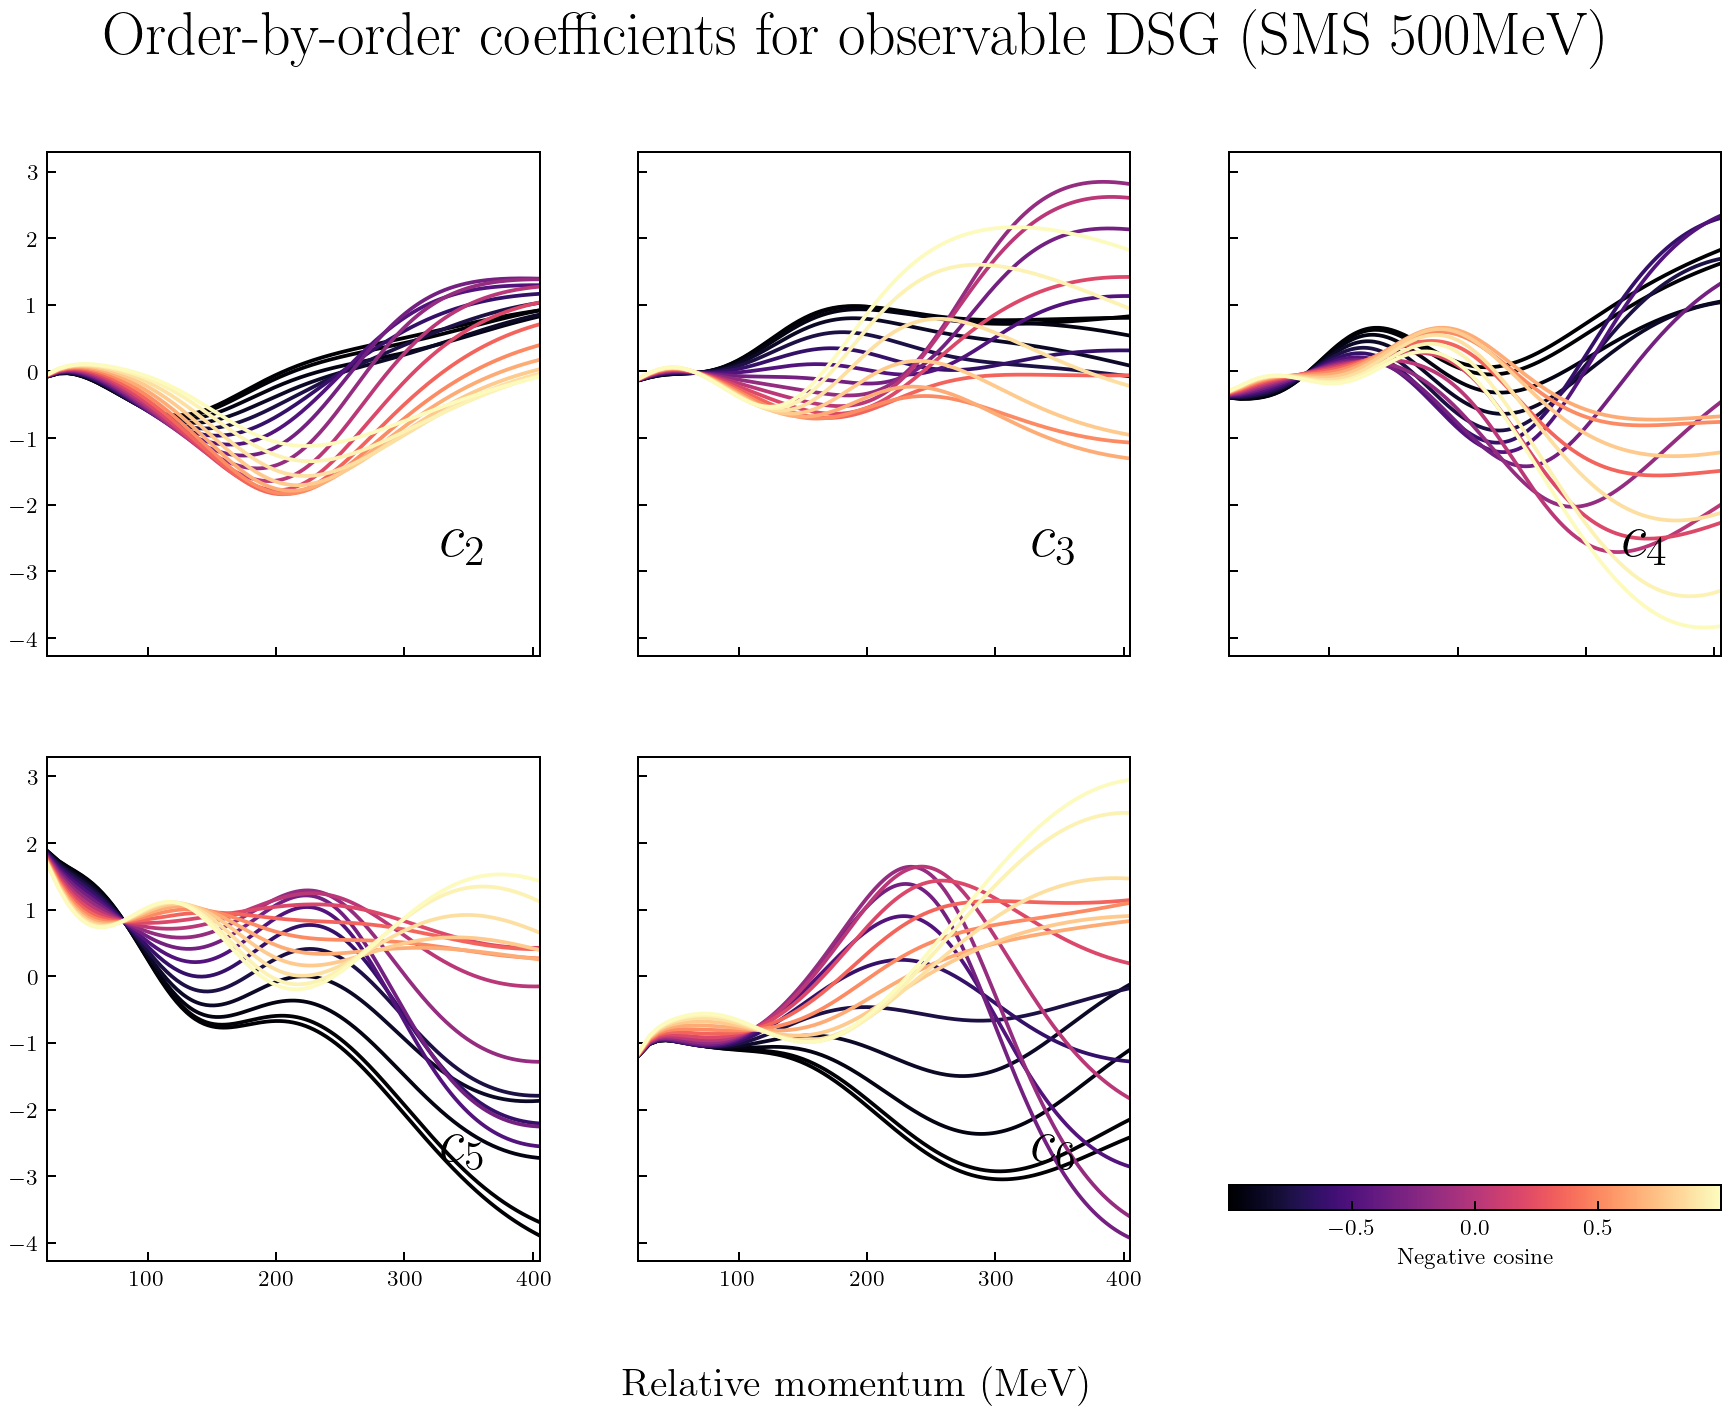

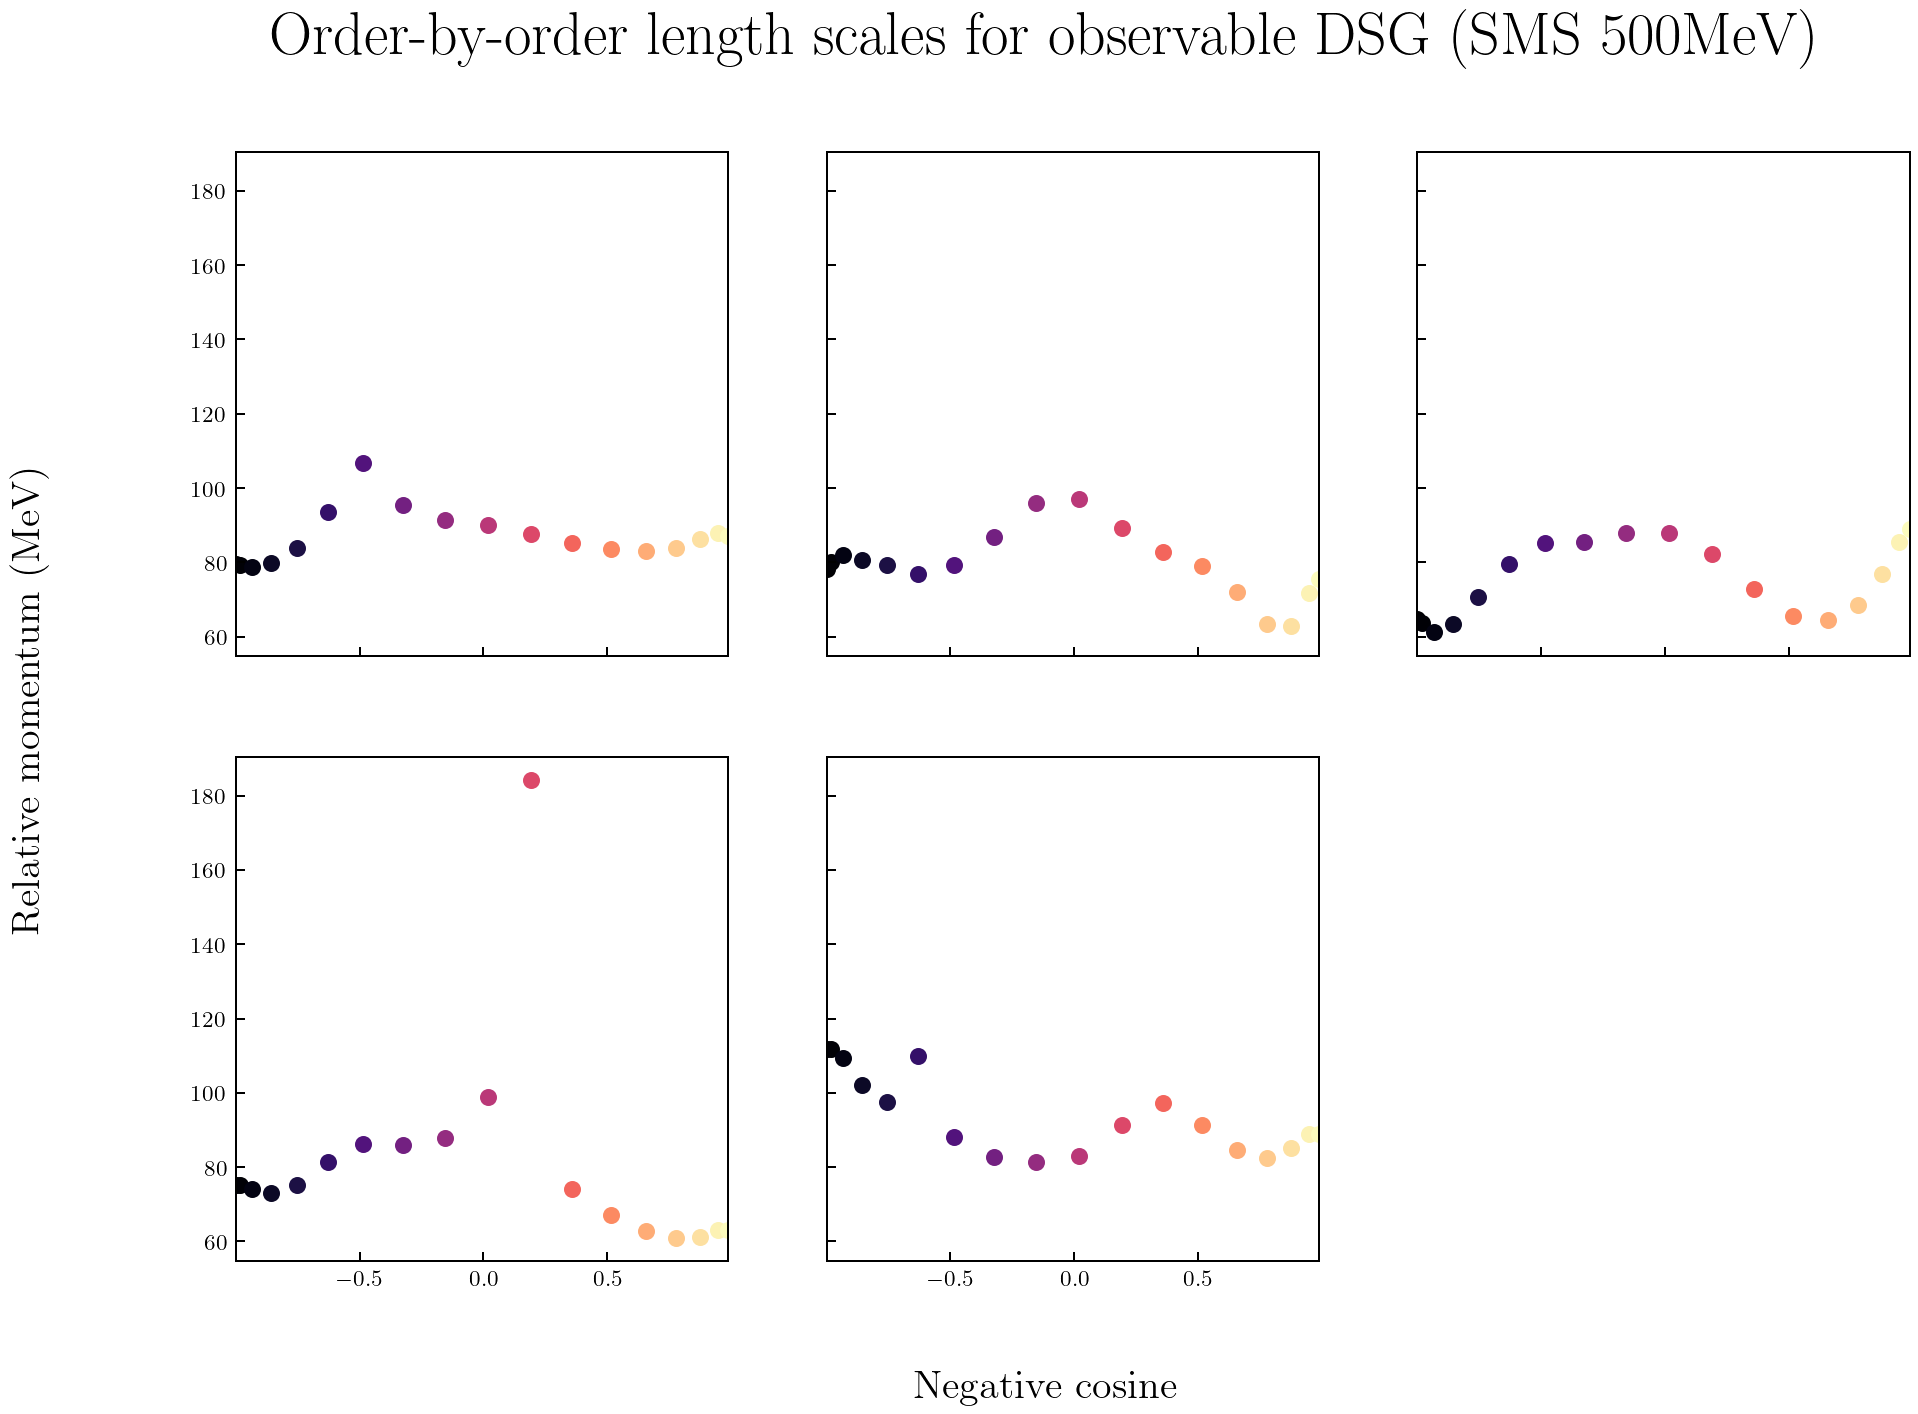

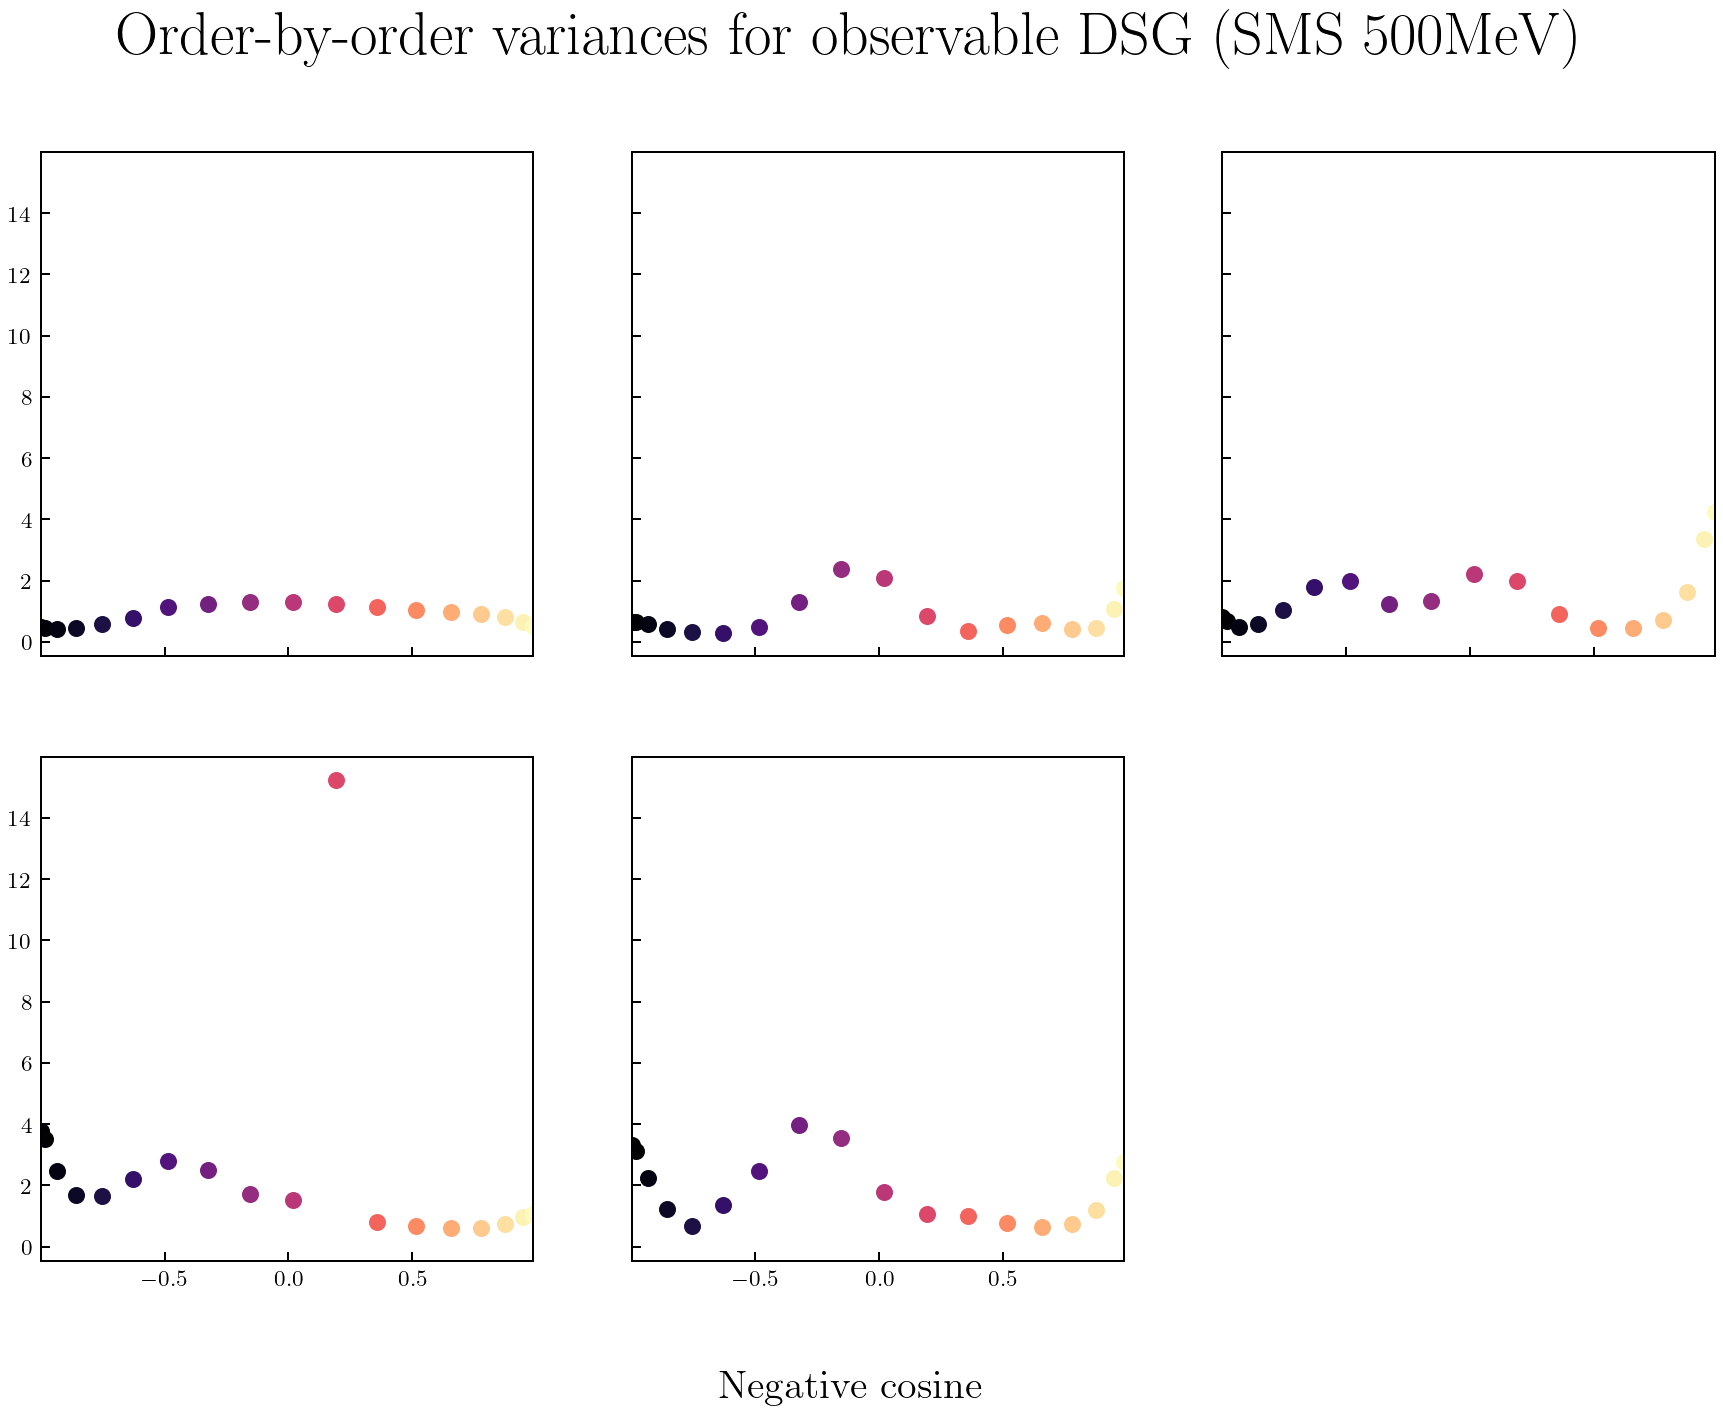

In [8]:
# choose colormap and fix to different energies
cmap_deg = mpl.cm.magma
norm_deg = mpl.colors.Normalize(vmin=np.min(degrees_input), vmax=np.max(degrees_input))

# create figure with n_orders subplots
fig_deg_coeffs, axs_deg_coeffs = plt.subplots(2, 3, sharex = True, sharey=True, figsize=(12, 8))
fig_deg_coeffs.supxlabel(t_lab_label, size = 16)
fig_deg_coeffs.suptitle('Order-by-order coefficients for observable ' + obs_data_name + " (" + 
             ScaleScheme.potential_string + " " + ScaleScheme.cutoff_string + ")", size = 24)

# create figure with n_orders subplots
fig_deg_ls, axs_deg_ls = plt.subplots(2, 3, sharex = True, sharey=True, figsize=(12, 8))
fig_deg_ls.supxlabel(degrees_label, size = 16)
fig_deg_ls.supylabel(t_lab_label, size = 16)
fig_deg_ls.suptitle('Order-by-order length scales for observable ' + obs_data_name + " (" + 
             ScaleScheme.potential_string + " " + ScaleScheme.cutoff_string + ")", size = 24)

# create figure with n_orders subplots
fig_deg_var, axs_deg_var = plt.subplots(2, 3, sharex = True, sharey=True, figsize=(12, 8))
fig_deg_var.supxlabel(degrees_label, size = 16)
fig_deg_var.suptitle('Order-by-order variances for observable ' + obs_data_name + " (" + 
             ScaleScheme.potential_string + " " + ScaleScheme.cutoff_string + ")", size = 24)

# plots at each angle in mesh
for o in range(1, np.shape(coeffs_surfaces)[0]):
    (axs_deg_coeffs.flat)[o - 1].text(0.8, 0.2, 
                       rf'$c_{{{ScaleScheme.orders_full[o]}}}$', 
                       transform=(axs_deg_coeffs.flat)[o - 1].transAxes, 
                       size = 24)
        
    for d in degrees_subset:
        (axs_deg_coeffs.flat)[o - 1].plot(t_lab_input, 
                    coeffs_surfaces[o, :, np.isin(degrees_input, d)].T, 
                    c = mpl.cm.ScalarMappable(norm=norm_deg, cmap=cmap_deg).to_rgba(d))
        
        gp = gm.ConjugateGaussianProcess(
            RBF(length_scale=60,
                      length_scale_bounds=(12, 300)) + \
                      WhiteKernel(1e-5, noise_level_bounds='fixed'), 
            center=0, 
            disp=0, 
            df=1,
            scale=1, 
            n_restarts_optimizer=100, 
            random_state=None,
            sd=None)
        gp.fit(X_train_tlab, 
               (coeffs_surfaces[o, :, np.isin(degrees_input, d)].T)[np.isin(t_lab_input, X_train_tlab)])
        ls_fit = np.exp(gp.kernel_.theta)
        (axs_deg_ls.flat)[o - 1].scatter(d, 
                    ls_fit, 
                    c = mpl.cm.ScalarMappable(norm=norm_deg, cmap=cmap_deg).to_rgba(d))
        
        pred, std = gp.predict(X_tlab, return_std=True)
        underlying_std = gp.cov_factor_
        (axs_deg_var.flat)[o - 1].scatter(d, 
                    underlying_std, 
                    c = mpl.cm.ScalarMappable(norm=norm_deg, cmap=cmap_deg).to_rgba(d))

fig_deg_coeffs.delaxes(axs_deg_coeffs[-1, -1])        
fig_deg_coeffs.colorbar(mpl.cm.ScalarMappable(norm=norm_deg, cmap=cmap_deg), 
            ax = axs_deg_coeffs[-1, -1],
             orientation='horizontal', label=degrees_label)

fig_deg_ls.delaxes(axs_deg_ls[-1, -1])
fig_deg_var.delaxes(axs_deg_var[-1, -1])

# saves figures
fig_deg_coeffs.savefig('figures2/' + 'coeffs' + '_' + 'deg_slices' + '_' + 'orderbyorder' + '_' +
                    ScaleScheme.potential_string + ScaleScheme.cutoff_string + '_' +
                    obs_data_name + '_Q' + Q_type + '_' + p_type + '_' + 'prel' + '_' + 
                    'degrees')
fig_deg_ls.savefig('figures2/' + 'ls' + '_' + 'deg_slices' + '_' + 'orderbyorder' + '_' +
                    ScaleScheme.potential_string + ScaleScheme.cutoff_string + '_' +
                    obs_data_name + '_Q' + Q_type + '_' + p_type + '_' + 'prel' + '_' + 
                    'degrees')
fig_deg_var.savefig('figures2/' + 'var' + '_' + 'deg_slices' + '_' + 'orderbyorder' + '_' +
                    ScaleScheme.potential_string + ScaleScheme.cutoff_string + '_' +
                    obs_data_name + '_Q' + Q_type + '_' + p_type + '_' + 'prel' + '_' + 
                    'degrees')

#### Plots of lab-energy length scale and variance over all orders

C:\Users\pjmil\AppData\Local\Temp\ipykernel_9768\4227609231.py:36: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  axs_deg_ls_all.scatter(d,
C:\Users\pjmil\AppData\Local\Temp\ipykernel_9768\4227609231.py:42: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  axs_deg_var_all.scatter(d,
C:\Users\pjmil\anaconda3\envs\modern-nn-potentials\lib\site-packages\gsum\models.py:891: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with

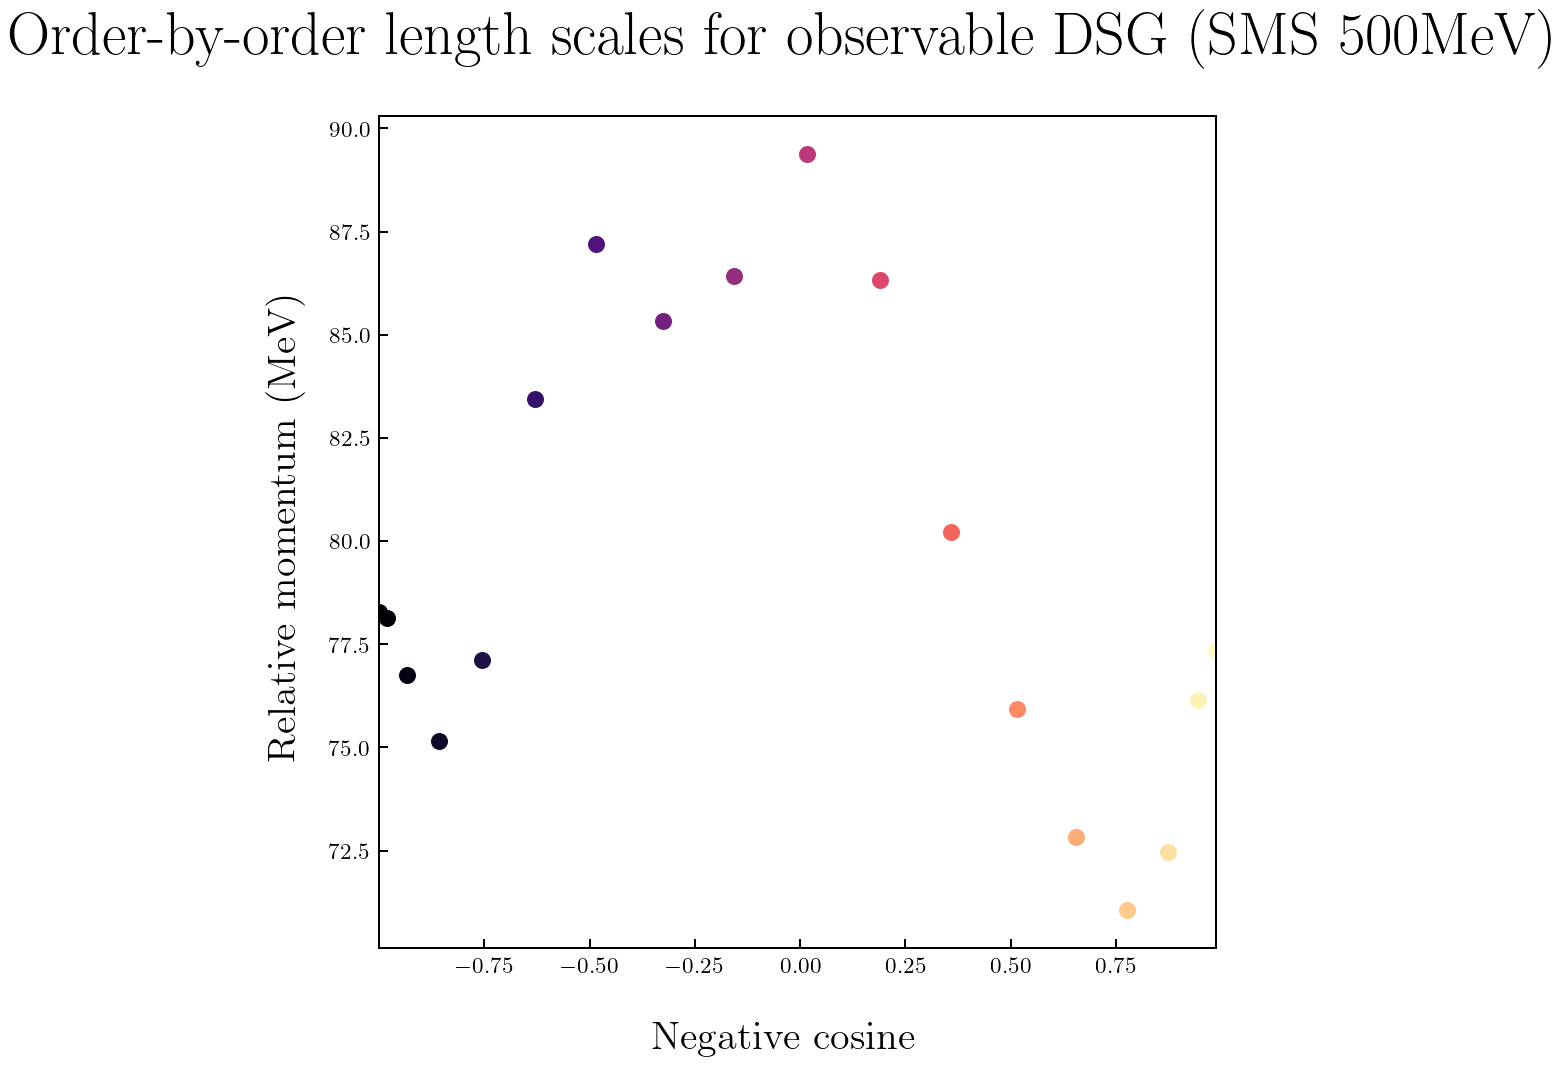

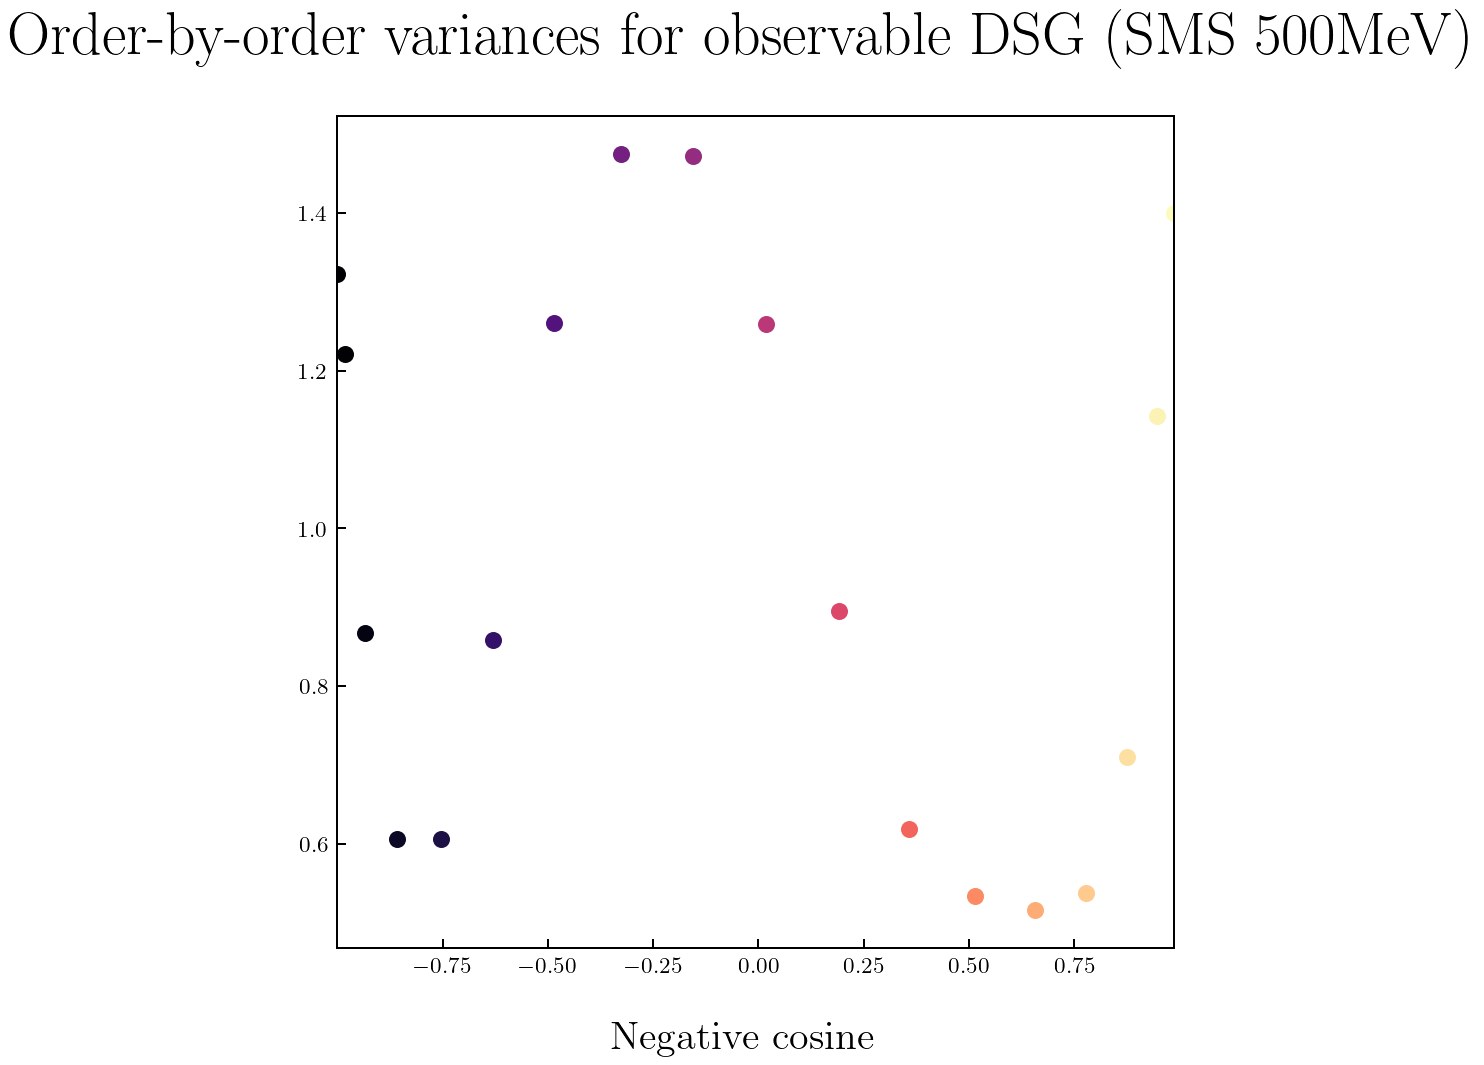

In [9]:
# create figure with n_orders subplots
fig_deg_ls_all, axs_deg_ls_all = plt.subplots(1, 1, sharex = True, sharey=True, figsize=(6, 6))
fig_deg_ls_all.supxlabel(degrees_label, size = 16)
fig_deg_ls_all.supylabel(t_lab_label, size = 16)
fig_deg_ls_all.suptitle('Order-by-order length scales for observable ' + obs_data_name + " (" + 
             ScaleScheme.potential_string + " " + ScaleScheme.cutoff_string + ")", size = 24)
# axs_deg_ls_all.semilogx()
# axs_deg_ls_all.semilogy()

# create figure with n_orders subplots
fig_deg_var_all, axs_deg_var_all = plt.subplots(1, 1, sharex = True, sharey=True, figsize=(6, 6))
fig_deg_var_all.supxlabel(degrees_label, size = 16)
fig_deg_var_all.suptitle('Order-by-order variances for observable ' + obs_data_name + " (" + 
             ScaleScheme.potential_string + " " + ScaleScheme.cutoff_string + ")", size = 24)
# axs_deg_var_all.semilogx()
# axs_deg_var_all.semilogy()

# plots at each angle in mesh
for d in degrees_subset:
    gp = gm.ConjugateGaussianProcess(
        RBF(length_scale=60,
                  length_scale_bounds=(12, 300)) + \
                  WhiteKernel(1e-5, noise_level_bounds='fixed'), 
        center=0, 
        disp=0, 
        df=1,
        scale=1, 
        n_restarts_optimizer=100, 
        random_state=None,
        sd=None)
    gp.fit(X_train_tlab, 
           np.reshape(coeffs_surfaces[:, :, np.isin(degrees_input, d)].T, 
                     (len(t_lab), 
                     np.shape(coeffs_surfaces)[0]))[np.isin(t_lab_input, X_train_tlab), :])
    ls_fit = np.exp(gp.kernel_.theta)
    axs_deg_ls_all.scatter(d, 
                ls_fit, 
                c = mpl.cm.ScalarMappable(norm=norm_deg, cmap=cmap_deg).to_rgba(d))

    pred, std = gp.predict(X_tlab, return_std=True)
    underlying_std = gp.cov_factor_
    axs_deg_var_all.scatter(d, 
                underlying_std, 
                c = mpl.cm.ScalarMappable(norm=norm_deg, cmap=cmap_deg).to_rgba(d))

# saves figures
fig_deg_ls_all.savefig('figures2/' + 'ls' + '_' + 'deg_slices' + '_' + 'allorders' + '_' +
                    ScaleScheme.potential_string + ScaleScheme.cutoff_string + '_' +
                    obs_data_name + '_' + Q_type + '_' + p_type + '_' + 'prel' + '_' + 
                    'degrees')
fig_deg_var_all.savefig('figures2/' + 'var' + '_' + 'deg_slices' + '_' + 'allorders' + '_' +
                    ScaleScheme.potential_string + ScaleScheme.cutoff_string + '_' +
                    obs_data_name + '_Q' + Q_type + '_' + p_type + '_' + 'prel' + '_' + 
                    'degrees')